In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split
sns.set_style('darkgrid')

In [2]:
df_spam = pd.read_csv("spam.csv", encoding='latin-1')

In [3]:
## Some basic sanity checks for the 3 data frame 
def nulldata(dataframe):
    total = dataframe.isnull().sum().sort_values(ascending = False)
    percent = (dataframe.isnull().sum()/dataframe.isnull().count()*100).sort_values(ascending = False)
    df_null=pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return(df_null)

print(nulldata(df_spam))

            Total    Percent
Unnamed: 4   5566  99.892319
Unnamed: 3   5560  99.784637
Unnamed: 2   5522  99.102656
v1              0   0.000000
v2              0   0.000000


We see that there are 3 columns with almost no data in them so removing them and renaming the two major columns in the dataset

In [4]:
# Exploring the data in the 3 unnamed columns to check if there is any thing of importance
print(df_spam[df_spam.columns.drop(['v1','v2'])].dropna(how='all').head(10))

# Checking if any of these messages contains spam or not
print(df_spam.loc[df_spam['v1'] == 'spam',df_spam.columns.drop(['v1','v2'])].dropna())

                                             Unnamed: 2  \
95                                          PO Box 5249   
281    the person is definitely special for u..... B...   
444    HOWU DOIN? FOUNDURSELF A JOBYET SAUSAGE?LOVE ...   
671    wanted to say hi. HI!!!\" Stop? Send STOP to ...   
710     this wont even start........ Datz confidence.."   
899                                         PO Box 5249   
1038                                                 GN   
1127                                           .;-):-D"   
1266  just been in bedbut mite go 2 thepub l8tr if u...   
1384   bt not his girlfrnd... G o o d n i g h t . . .@"   

                 Unnamed: 3                      Unnamed: 4  
95     MK17 92H. 450Ppw 16"                             NaN  
281        why to miss them   just Keep-in-touch\" gdeve.."  
444                     NaN                             NaN  
671                     NaN                             NaN  
710                     NaN             

None of the unnamed columns contains spam messages and 99% of them are empty hence we are dropping them from our analysis

In [5]:
df_spam.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1, inplace=True)
# renaming the columns
df_spam.columns = ["spam_label","message"]
df_spam.head()


,spam_label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


percentage of labels:               message
spam_label           
ham         86.593683
spam        13.406317


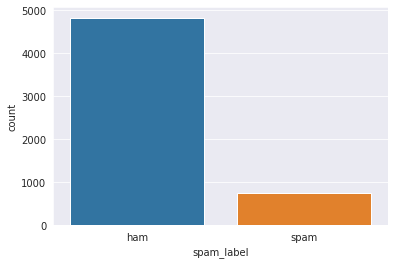

In [6]:
sns.countplot(data=df_spam,x='spam_label')
print("percentage of labels:",f"{100*df_spam.groupby('spam_label').count()/len(df_spam)}")

Now lets look at the distribution of message length to understand if theres is any underlying pattern in the spam messages

In [7]:
df_spam["msg_len"]=df_spam.apply(lambda row: len(row.message),axis=1)

Text(0.5, 0, 'Message Length  (in characters)')

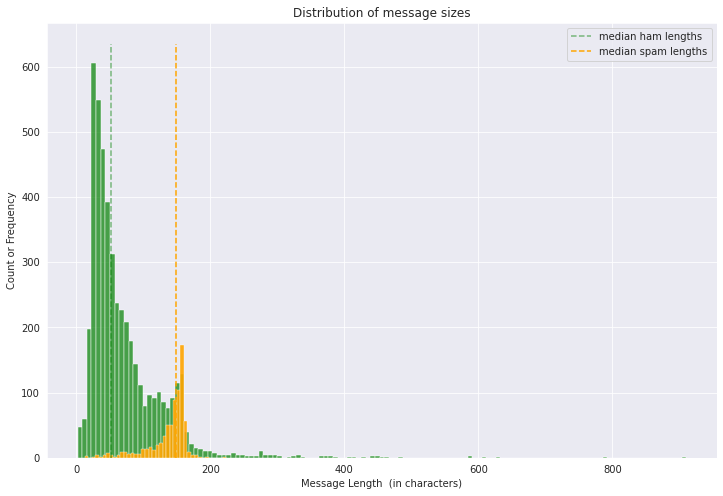

In [8]:
fig,ax=plt.subplots(figsize=(12,8))
check = 'ham'
sns.histplot(df_spam[df_spam['spam_label']==check],x='msg_len',color='green',ax=ax,alpha=0.7)
ymin, ymax = plt.gca().get_ylim()
plt.vlines(x=df_spam.loc[df_spam['spam_label']==check,'msg_len'].median(),ymin=ymin,ymax=ymax,color='green',alpha=0.5,linestyles='dashed')
check = 'spam'
sns.histplot(df_spam[df_spam['spam_label']==check],x='msg_len',color='orange',ax=ax,alpha=0.9)
plt.vlines(x=df_spam.loc[df_spam['spam_label']==check,'msg_len'].median(),ymin=ymin,ymax=ymax,color='orange',linestyles='dashed')
plt.legend(['median ham lengths','median spam lengths'])
plt.title('Distribution of message sizes')
plt.ylabel('Count or Frequency')
plt.xlabel('Message Length  (in characters)')

The median of both the frequency distributions indicate that non spam messages are mostly short and spam messages are lengthy. Hence we can use the length of messages as a feature while training the model.

However as the plan is to check how FLAIR works in the classification task we will try to stick to using flair embedding for our classfication task and compare it with a classical NLP based baseline

### Baseline model

In [9]:
# Importing libraries for NLP based feature engineering

#importing functions that helps in feature engineering
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string


from sklearn.pipeline import FeatureUnion 
#FeatureUnion is used to concat feaatures obtained using different transform functions
from sklearn.preprocessing import FunctionTransformer
#FunctionTransformer can create a transform function from any arbitrary or user defined function
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

In [10]:
#stop word removal
remove_list = set(list(string.punctuation) + stopwords.words('english'))
#defining a function that can tokenize the messages, remove unwanted words and punctuations
porterstemmer = PorterStemmer()


def get_clean_message(message):
    cleaned_message = []
    for word in word_tokenize(message.lower()):
        word = re.sub('[^a-zA-Z]','',word)
        if(word == ''):
            continue
        if(word not in remove_list):
            cleaned_message.append(porterstemmer.stem(word))
    return cleaned_message

def get_length(df):
    df = df.apply(len)
    return csr_matrix(df.to_numpy().reshape(-1,1))


In [11]:
feature_pipe = FeatureUnion([
    ('tfidf',TfidfVectorizer(analyzer=get_clean_message))])

In [12]:
# Dividing the data set into train validation and test set

df_spam['spam_flag'] = df_spam['spam_label'].map(lambda x: 0 if(x=='ham') else 1)

# train is now 75% of the entire data set
# the _junk suffix means that we drop that variable spam_labelcompletely
x_train, x_test, y_train, y_test = train_test_split(df_spam["message"], df_spam["spam_flag"], test_size=0.20,random_state=11)


print(len(x_train), len(x_test))

4457 1115


In [13]:
tfidf_mat = feature_pipe.fit_transform(list(x_train))
tfidf_mat_len = hstack(
            (
                tfidf_mat,
                get_length(x_train),
            )
        ).tocsr()

In [14]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix

In [15]:
#define grid search
params =  {'alpha':[0.001,0.01,0.1,0.25,0.3,0.35,0.5,0.6,0.7,0.8,0.9,1,2,5]}
grid = GridSearchCV(MultinomialNB(),param_grid=params,cv=6,scoring='recall')
grid.fit(tfidf_mat,y_train)



GridSearchCV(cv=6, estimator=MultinomialNB(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 0.25, 0.3, 0.35, 0.5, 0.6,
                                   0.7, 0.8, 0.9, 1, 2, 5]},
             scoring='recall')

In [16]:
test_mat = feature_pipe.transform(list(x_test))
test_mat_len = hstack(
            (
                test_mat,
                get_length(x_test),
            )
        ).tocsr()

In [17]:
#print accuracy score
print(f'Accuracy score is: {grid.score(test_mat,y_test):.2f}')
#Print the best parameter
print('Best parameter:',grid.best_params_)

Accuracy score is: 0.93
Best parameter: {'alpha': 0.1}


In [19]:
#classify test messages
predictions = grid.predict(test_mat)
#print classification report
print(classification_report(y_test,predictions))

print(confusion_matrix(y_test,predictions))


              precision    recall  f1-score   support

           0       0.99      1.00      0.99       982
           1       0.98      0.93      0.95       133

    accuracy                           0.99      1115
   macro avg       0.98      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115

[[979   3]
 [  9 124]]


In [ ]:
confusion_matrix(y_test,predictions)

In [ ]:
# Importing the flair modules

from flair.data import Corpus
from flair.datasets import CSVClassificationCorpus
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentLSTMEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
from pathlib import Path

In [ ]:
import pandas as pd
data = pd.read_csv("spam.csv", encoding='latin-1').sample(frac=1).drop_duplicates()

data = data[['v1', 'v2']].rename(columns={"v1":"label", "v2":"text"})
 
data['label'] = '__label__' + data['label'].astype(str)

data.iloc[0:int(len(data)*0.8)].to_csv('train.csv', sep='\t', index = False, header = False)
data.iloc[int(len(data)*0.8):int(len(data)*0.9)].to_csv('test.csv', sep='\t', index = False, header = False)
data.iloc[int(len(data)*0.9):].to_csv('dev.csv', sep='\t', index = False, header = False);

In [ ]:
from flair.data import Corpus
from flair.datasets import ClassificationCorpus

# this is the folder in which train, test and dev files reside
data_folder = './'

# load corpus containing training, test and dev data
corpus: Corpus = ClassificationCorpus(data_folder,
                                      test_file='test.csv',
                                      dev_file='dev.csv',
                                      train_file='train.csv')

In [ ]:
word_embeddings = [WordEmbeddings('glove'), FlairEmbeddings('news-forward-fast'), FlairEmbeddings('news-backward-fast')]
document_embeddings = DocumentLSTMEmbeddings(word_embeddings, hidden_size=512, reproject_words=True, reproject_words_dimension=256)
classifier = TextClassifier(document_embeddings, label_dictionary=corpus.make_label_dictionary(), multi_label=False)
trainer = ModelTrainer(classifier, corpus)


In [ ]:
trainer.train('./',
                  learning_rate=0.05,
                  mini_batch_size=50,
                  anneal_factor=0.5,
                  patience=3,
                  max_epochs=1,embeddings_storage_mode='none')


In [ ]:
import csv
with open('dev1.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter='\t', quotechar='|')
    for i,row in enumerate(spamreader):
        pass

In [ ]:
i

By class:
              precision    recall  f1-score   support

         ham     0.9892    0.9935    0.9913       460
        spam     0.9455    0.9123    0.9286        57

macro avg     0.9673    0.9529    0.9599       517

In [ ]:
macro avg       0.97      0.96      0.97      1393

In [ ]:
df_spam.groupby("spam_label").count()

In [ ]:
print("percentage of labels:",f"{100*df_spam.groupby('spam_label').count()/len(df_spam)}")

print("count of labels:",f"{100*df_spam.groupby('spam_label').count()}")

In [ ]:
type(x_train)

In [ ]:
tfidf_mat.shape

In [ ]:
feature_pipe

In [ ]:
def get_feature_pipe():
    feature_pipe = FeatureUnion([
    ('tfidf',TfidfVectorizer(analyzer=get_clean_message))])
    tfidf_mat = feature_pipe.fit_transform(list(x_train))
    
    return tfidf_mat,feature_pipe

In [ ]:
tfidf_mat,feature = get_feature_pipe()

In [ ]:
feature.transform(list(x_test))

In [ ]:
print(feature.transform(["Thanks again for your reply today. When is ur visa coming in. And r u still buying the gucci and bags."]))

In [ ]:
train_split = 0.8
train_split+0.1

In [ ]:
corpus.obtain_statistics()

In [ ]:
from flair.datasets import ClassificationDataset

In [ ]:
train: FlairDataset = ClassificationDataset(
            "train.csv",
            label_type="class",
            tokenizer=tokenizer,
            truncate_to_max_tokens=truncate_to_max_tokens,
            truncate_to_max_chars=truncate_to_max_chars,
            filter_if_longer_than=filter_if_longer_than,
            memory_mode=memory_mode,
            label_name_map=label_name_map,
            skip_labels=skip_labels,
            allow_examples_without_labels=allow_examples_without_labels,
            encoding=encoding,
        )

In [ ]:
type(grid)

In [ ]:
type(feature_pipe)

In [ ]:
from flair.models import TextClassifier
from flair.data import Sentence
classifier = TextClassifier.load('./final-model.pt')
sentence = Sentence('Hi. Yes mum, I will...')
classifier.predict(sentence)

In [ ]:
type(sentence.get_labels())

In [ ]:
sentence.get_labels()[0].to_dict()

In [ ]:
PATH = "./"
import os
import pickle
import joblib

In [ ]:
PATH = "./"

In [ ]:
pickle.dump(feature_pipe, open(os.path.join(PATH, f"feature_vector.pickle"), "wb"))
joblib.dump(grid, os.path.join(PATH, f"grid_model.pickle"))

In [ ]:
feature_pipe_a = pickle.load(open(os.path.join(PATH, f"feature_vector.pickle"), "rb"))
grid_model_a = joblib.load(os.path.join(PATH, f"grid_model.pickle"))

In [ ]:
os.path.join(PATH, f"feature_vector.pickle")

In [ ]:
test_mat = feature_pipe_a.transform([x_test[4460]])
test_mat_len = hstack(
            (
                test_mat,
                get_length(pd.series(list(x_test[4460]))),
            )
        ).tocsr()

In [ ]:
grid_model_a.predict(test_mat)

In [ ]:
grid_model_a.predict(test_mat)

In [ ]:
type(x_test)

In [ ]:
grid_model_a.pre

In [ ]:
sentences = pd.DataFrame(list(x_test[:3]),columns=["sentence"])

In [ ]:
sent_mat = feature_pipe_a.transform(sentences["sentence"])
sent_mat_len = hstack(
            (
                sent_mat,
                get_length(sentences["sentence"]),
            )
        ).tocsr()

In [ ]:
grid_model_a.predict_log_proba(sent_mat)

In [ ]:
grid_model_a.predict(sent_mat)

In [ ]:
list(x_test[:3])

In [ ]:
type(grid_model_a)

In [ ]:
import  csv

messages = list(x_test[:3])

with open("new_messages.csv","w") as f:
    wr = csv.writer(f,delimiter="")
    wr.writerow(messages)

In [ ]:
pd.DataFrame(messages)

In [ ]:
messages